In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
QSO_name = 'PG1522+101'

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/' + QSO_name + '/STIS/'

In [4]:
file_list = glob.glob(rootdir + 'Old/Unstitched/*x1d.fits')

In [5]:
fits_list = [fits.open(f) for f in file_list]

In [6]:
n_exps = len(fits_list)
n_orders = fits_list[0][1].data.shape[0]
n_pixels = fits_list[0][1].data[0][2].shape[0]

In [7]:
n_rej = int(.05*n_pixels)+1

In [47]:
n_rej

52

In [8]:
n_pixels = n_pixels-2*n_rej

In [9]:
fits_list[0][1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                38946 / width of table in bytes                        
NAXIS2  =                   29 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   19 / number of fields in each row                   
TTYPE1  = 'SPORDER '           / label for field   1                            
TFORM1  = '1I      '           / data format of field: 2-byte INTEGER           
TTYPE2  = 'NELEM   '           / label for field   2                            
TFORM2  = '1I      '           / data format of field: 2-byte INTEGER           
TTYPE3  = 'WAVELENGTH'      

In [10]:
n_exps, n_orders, n_pixels

(8, 29, 920)

In [11]:
# From all exposures, all orders, all pixels, load in wavelengths, fluxes, errors, and data quality
spec_data = np.zeros((n_exps, n_orders, n_pixels, 4))

In [12]:
for i in range(n_exps):
    for j in range(n_orders):
        # Load orders in reverse because that means increasing wavelengths
        spec_data[i,j,:,0] = fits_list[i][1].data[n_orders-j-1][2][n_rej:-n_rej]
        spec_data[i,j,:,1] = fits_list[i][1].data[n_orders-j-1][6][n_rej:-n_rej]
        spec_data[i,j,:,2] = fits_list[i][1].data[n_orders-j-1][7][n_rej:-n_rej]
        spec_data[i,j,:,3] = fits_list[i][1].data[n_orders-j-1][9][n_rej:-n_rej]

In [13]:
wav_order_grid = np.zeros((n_orders, n_pixels))
wav_order_grid[0,:] = spec_data[0,0,:,0]

In [14]:
for i in range(n_orders-1):

    # Wavelengths of order 1
    wav_order_1 = spec_data[0,i,:,0]
    # Wavelengths of order 2
    wav_order_2 = spec_data[0,i+1,:,0]
    
    # Compute differences of order 1 wavelengths from the 0th element of order 2
    del_wav_arr = wav_order_1-wav_order_2[0]

    # This gives the index of the element of order 1 whose wavelength is right before the 0th element of order 2
    idx = list(del_wav_arr).index(max(del_wav_arr[del_wav_arr<0]))

    n_rem_order_1 = len(wav_order_1[idx:])

    wav_order_2[0:n_rem_order_1] = wav_order_1[idx:].copy()

    wav_order_grid[i+1,:] = wav_order_2.copy()

In [15]:
spec_data_interp = spec_data.copy()

In [16]:
for i in range(n_exps):
    for j in range(n_orders):
        
        wav_order = wav_order_grid[j,:]
    
        wav_order_og = spec_data[i,j,:,0]
        flux_order_og = spec_data[i,j,:,1]
        var_order_og = spec_data[i,j,:,2]**2
        dq_order_og = spec_data[i,j,:,3]
        
        # Only get points with good data quality for interpolatings
        idx = dq_order_og==0
        #idx = (dq_order_og==0) | (dq_order_og==4)
        
        flux_order = np.interp(wav_order, wav_order_og[idx], flux_order_og[idx])
        var_order = np.interp(wav_order, wav_order_og[idx], var_order_og[idx])
        
        spec_data_interp[i,j,:,0] = wav_order
        spec_data_interp[i,j,:,1] = flux_order
        spec_data_interp[i,j,:,2] = np.sqrt(var_order)

In [17]:
SN = np.array(spec_data_interp[:,:,:,1].flatten()/spec_data_interp[:,:,:,2].flatten())

In [18]:
np.max(SN)

5.796885451431566

(-10.0, 10.0)

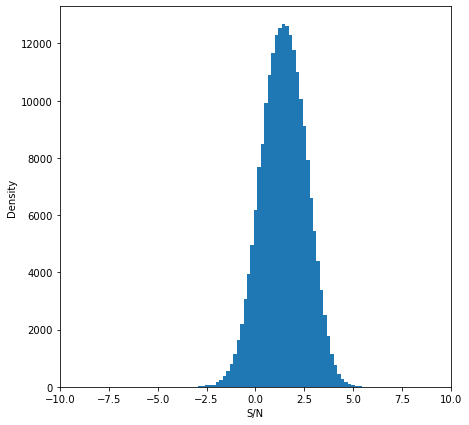

In [19]:
fig, ax = plt.subplots(1, figsize=(7,7))

ax.hist(SN, bins=60)

ax.set_xlabel('S/N')
ax.set_ylabel('Density')

ax.set_xlim(-10,10)

In [20]:
wav_dict = {w:[] for w in np.unique(wav_order_grid)}

In [21]:
for i in range(n_exps):
    for j in range(n_orders):
        for k in range(n_pixels):
            
            w = spec_data_interp[i,j,k,0]
            f = spec_data_interp[i,j,k,1]
            s = spec_data_interp[i,j,k,2]
            dq = spec_data_interp[i,j,k,3]
            
            wav_dict[w].append([f,s,dq])

In [22]:
wav_stitch = np.unique(wav_order_grid)

In [23]:
flux_stitch = np.zeros(len(wav_stitch))
err_stitch = np.zeros(len(wav_stitch))

In [24]:
for i in range(len(wav_stitch)):
    
    # Get wavelength, and quantities (flux, error) to be combined
    w = wav_stitch[i]
    spec_arr = np.array(wav_dict[w])
    flux_arr = spec_arr[:,0]
    err_arr = spec_arr[:,1]

    wts_arr = 1/err_arr**2
    
    wts_arr /= np.sum(wts_arr)
    
    flux_stitch[i] = np.sum(wts_arr*flux_arr)
    err_stitch[i] = np.sqrt(np.sum(wts_arr**2*err_arr**2))

Text(0, 0.5, 'Flux (ergs/cm^2/s)')

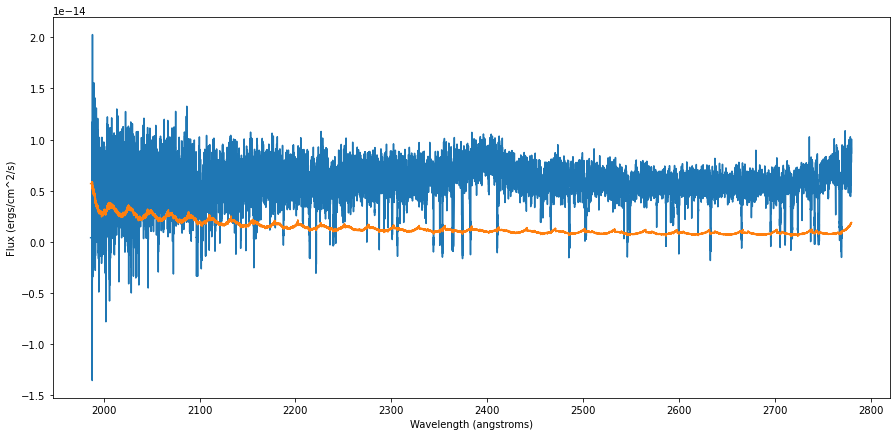

In [25]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch, flux_stitch)
ax.plot(wav_stitch, err_stitch)

ax.set_xlabel('Wavelength (angstroms)')
ax.set_ylabel('Flux (ergs/cm^2/s)')

Compare with old stitch

In [26]:
spec_data_old = fits.open(rootdir + 'Old/Stitched/' + QSO_name + '_E230M.fits')

In [27]:
spec_stitch_old = pd.DataFrame(spec_data_old[1].data).to_numpy()

In [28]:
wav_stitch_old = spec_stitch_old[:,0]
flux_stitch_old = spec_stitch_old[:,1]
err_stitch_old = spec_stitch_old[:,2]

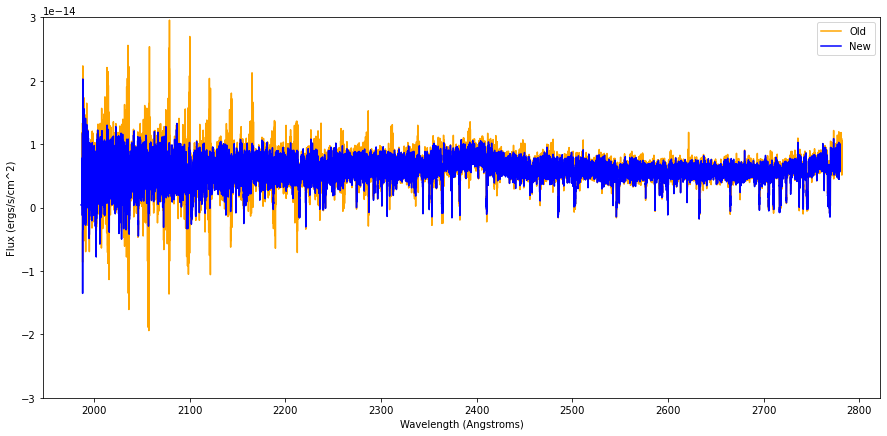

In [29]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, flux_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, flux_stitch, label='New', color='blue')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (ergs/s/cm^2)')

#ax.set_xlim(2065.5,2065.7)
ax.set_ylim(-3e-14,3e-14)
#ax.set_xlim()
ax.legend()

(-1e-15, 1.9e-14)

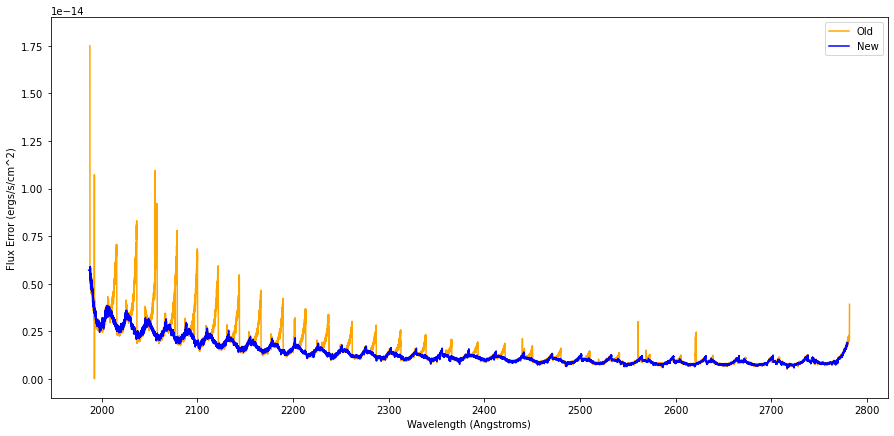

In [30]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, err_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, err_stitch, label='New', color='blue')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux Error (ergs/s/cm^2)')
ax.legend()

#ax.set_xlim(2065.5,2065.7)
ax.set_ylim(-1e-15,1.9e-14)

In [31]:
spec_data.shape

(8, 29, 920, 4)

Zoom-in plots

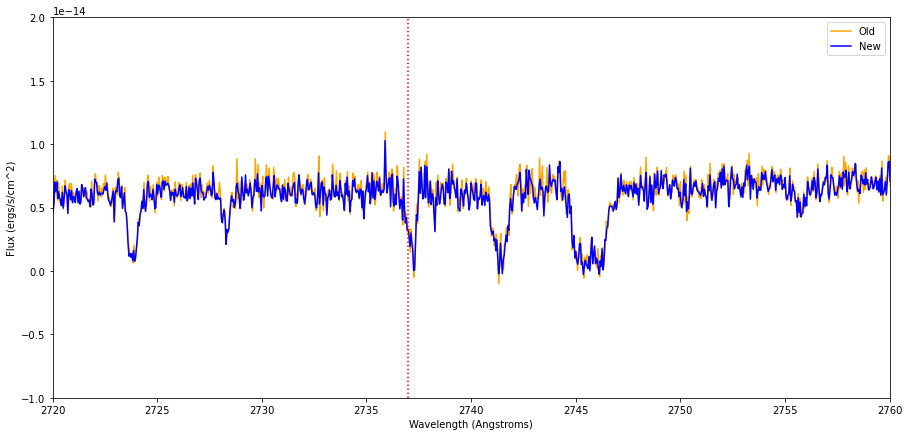

In [32]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, flux_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, flux_stitch, label='New', color='blue')
ax.axvline(2737, color='red', linestyle=':')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (ergs/s/cm^2)')

ax.set_xlim(2720, 2760)
ax.set_ylim(-1e-14,2e-14)
#ax.set_xlim()
ax.legend()

(4e-16, 1.5e-15)

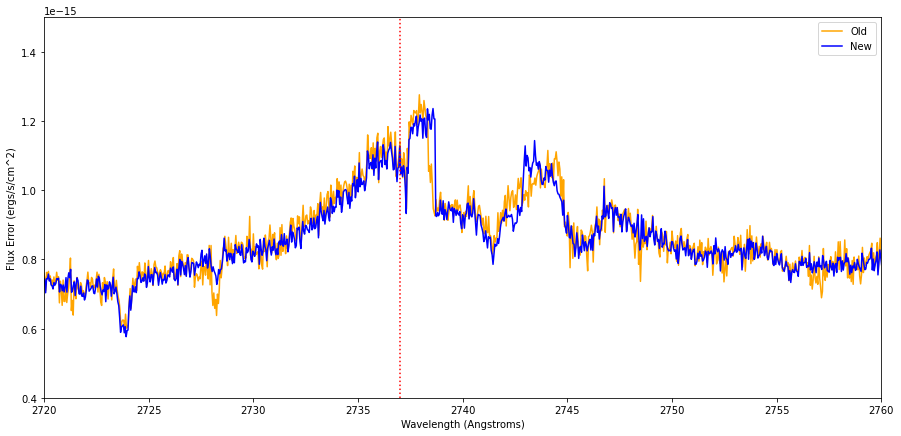

In [33]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, err_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, err_stitch, label='New', color='blue')
ax.axvline(2737, color='red', linestyle=':')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux Error (ergs/s/cm^2)')
ax.legend()


ax.set_xlim(2720, 2760)
ax.set_ylim(4e-16,1.5e-15)

Another zoom-in plot

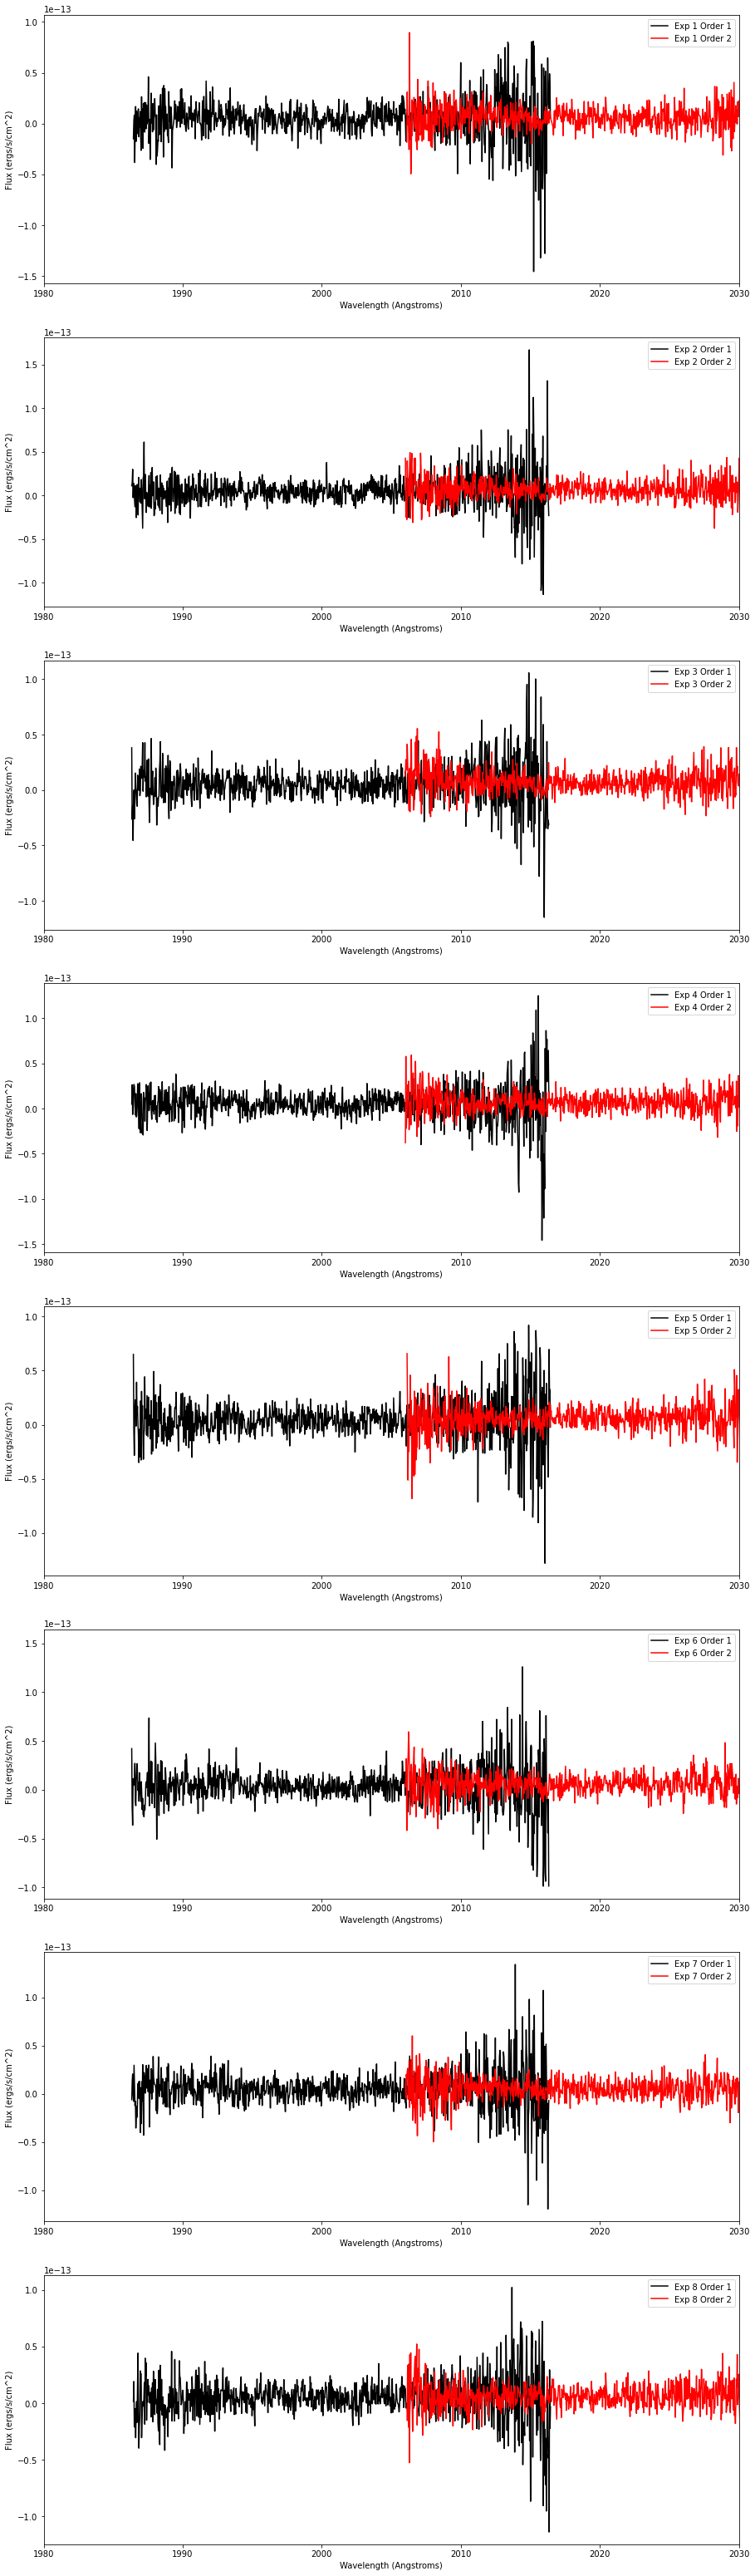

In [34]:
fig, axes = plt.subplots(n_exps, 1, figsize=(15,n_exps*7))

for i in range(n_exps):
    
    ax = axes[i]
    
    ax.plot(spec_data[i,0,:,0], spec_data[i,0,:,1], label='Exp {} Order 1'.format(str(i+1)), color='black')
    ax.plot(spec_data[i,1,:,0], spec_data[i,1,:,1], label='Exp {} Order 2'.format(str(i+1)), color='red')
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Flux (ergs/s/cm^2)')

    ax.set_xlim(1980, 2030)
    #ax.set_ylim(-1e-14,2e-14)
    #ax.set_xlim()
    ax.legend()

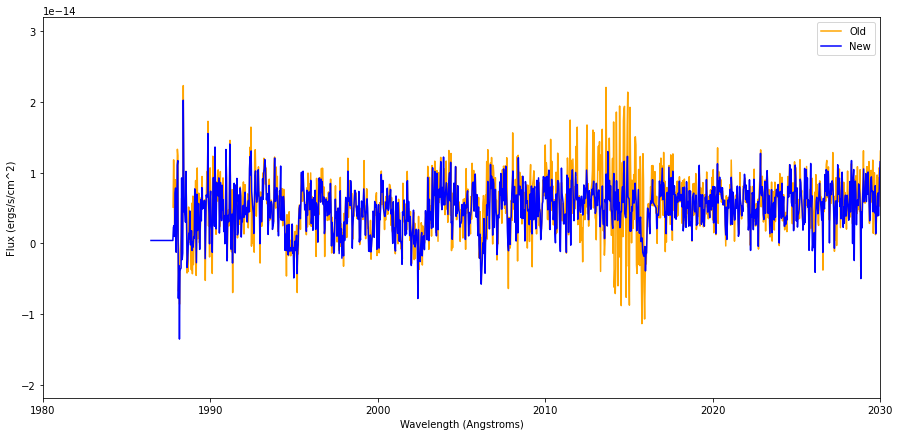

In [35]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, flux_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, flux_stitch, label='New', color='blue')
ax.axvline(2737, color='red', linestyle=':')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (ergs/s/cm^2)')

ax.set_xlim(1980, 2030)
#ax.set_ylim(-1e-14,2e-14)
#ax.set_xlim()
ax.legend()

(1980.0, 2030.0)

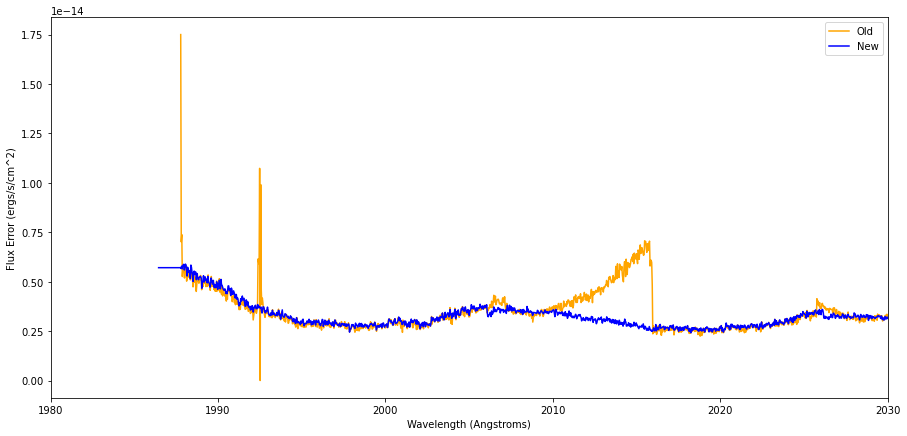

In [36]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch_old, err_stitch_old, label='Old', color='orange')
ax.plot(wav_stitch, err_stitch, label='New', color='blue')
ax.axvline(2737, color='red', linestyle=':')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux Error (ergs/s/cm^2)')
ax.legend()

ax.set_xlim(1980, 2030)
#ax.set_ylim(4e-16,1.5e-15)

Load in the current STIS file

In [37]:
spec_data_curr = fits.open(rootdir + '/' + QSO_name + '_E230M_new.fits')

In [38]:
spec_data_curr.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/STIS//PG1522+101_E230M_new.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     30   20628R x 11C   [D, D, D, D, D, D, D, D, D, K, D]   


In [39]:
spec_data_curr[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88 / length of dimension 1                          
NAXIS2  =                20628 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'wave    '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'error   '        

In [40]:
spec_arr_curr = pd.DataFrame(spec_data_curr[1].data).to_numpy()

In [41]:
spec_arr_curr

array([[ 1.98524279e+03,  1.01004040e-14,  8.81466351e-15, ...,
         0.00000000e+00,  1.00000000e+00,  6.19125305e-15],
       [ 1.98527551e+03,  3.81907065e-15,  8.53746411e-15, ...,
         0.00000000e+00,  1.00000000e+00,  6.18787918e-15],
       [ 1.98530822e+03, -5.65404682e-15,  8.75923018e-15, ...,
         0.00000000e+00,  1.00000000e+00,  6.18452458e-15],
       ...,
       [ 2.78145394e+03,  6.83344727e-15,  2.12415823e-15, ...,
         0.00000000e+00,  1.00000000e+00,  8.90487955e-15],
       [ 2.78149862e+03,  8.16841640e-15,  2.17703644e-15, ...,
         0.00000000e+00,  1.00000000e+00,  8.88373871e-15],
       [ 2.78154331e+03,  9.05187530e-15,  2.16281908e-15, ...,
         0.00000000e+00,  1.00000000e+00,  8.85840401e-15]])

In [42]:
continuum = spec_arr_curr[:,10]

Write out in a new format

In [43]:
c1 = fits.Column(name='wave    ', array=wav_stitch, format='D')
c2 = fits.Column(name='flux    ', array=flux_stitch, format='D')
c3 = fits.Column(name='error   ', array=err_stitch, format='D')
c4 = fits.Column(name='error_u ', array=err_stitch, format='D')
c5 = fits.Column(name='error_d ', array=err_stitch, format='D')
c6 = fits.Column(name='counts_total', array=np.zeros(len(wav_stitch)), format='D')
c7 = fits.Column(name='counts_net', array=np.zeros(len(wav_stitch)), format='D')
c8 = fits.Column(name='npix    ', array=np.zeros(len(wav_stitch)), format='D')
c9 = fits.Column(name='exptime ', array=np.zeros(len(wav_stitch)), format='D')
c10 = fits.Column(name='mask    ', array=np.ones(len(wav_stitch)), format='K')
c11 = fits.Column(name='continuum', array=continuum, format='D')

In [44]:
table_hdu = fits.BinTableHDU.from_columns([c1, c2, c3, 
                                           c4, c5, c6, 
                                           c7, c8, c9, 
                                           c10, c11])

In [45]:
hdu = fits.HDUList([spec_data_old[0], table_hdu])

In [46]:
#hdu.writeto(rootdir + QSO_name + '_E230M_new_pabs0.fits')